In [1]:
import os
import numpy as np
import pandas as pd
os.environ["NAMESPACE"]="research"
os.environ["PROFILE"]="local"
from agrobrain_util.runtime.evironment import RuntimeEnv
from agrobrain_util.infra.app_config import application_config as cfg

from skimage import io
import matplotlib.pyplot as plt
import json
import random
import glob
import datetime
from tqdm import tqdm
from datetime import datetime


env = RuntimeEnv()
categories_dict = cfg['tags']['categories']

could not find stamp in environment variables
could not find stamp in environment variables
could not find KUBEFLOW_API_BASIC_AUTH_TOKEN in environment variables
could not find AI_RABBITMQ_CONNECTION_STRING in environment variables
could not find AI_MONGO_DB_CONNECTION_STRING in environment variables
could not find TARANIS_DB_CONNECTION_STRING in environment variables
could not find GLOBAL_DB_CONNECTION_STRING in environment variables
could not find AI_MONGO_DB_CONNECTION_STRING_NEW in environment variables


In [2]:
# INITIALIZE - READ WEEDS_IMAGES_DF, FILTERED_IMAGES_DF, CREATE CATEGORIES DICTIONARY
def get_wide_images_list(current_df):
    l  = []
    for i in tqdm(range(0, len(current_df['imageID']), 10)):
        # print(current_df['imageID'][i])
        wide_image_id = env.eti_api.get_matching_wide_images(list(current_df['imageID'][i:i+10]))
        # print(wide_image_id)
        l.append(wide_image_id)
    wide_images_list = [item for sublist in l for item in sublist]
    return wide_images_list

def create_cat_dict(cat_list):
    cat_dict_types = {}
    cat_dict_names = {}
    for l in cat_list:
        cat_dict_types[l['id']] = l['type']
        if 'name' in l:
            cat_dict_names[l['id']] = l['name']
        else:
            cat_dict_names[l['id']] = 'NoName'
    cat_dict_types[0] = None
    cat_dict_names[0] = None
    return cat_dict_types, cat_dict_names

# READ FILTERED DATAFRAME - ONLY THE IMAGES THAT CONTAINES WEEDS. ADDING WEEDS DATA LIKE TYPE IDS, NAME, COVARAGE
weeds_images_df = pd.read_csv("/mnt/disks/datasets/wide_images/weeds_images_df.csv")
weeds_images_df['weed_types_ids_list'] = weeds_images_df['weed_types_ids_list'].apply(eval)
weeds_images_df['uploadDate_time'] = weeds_images_df['uploadDate'].apply(datetime.fromtimestamp)
weeds_images_df['uploadDate_date'] = weeds_images_df['uploadDate_time'].apply(lambda x: x.to_pydatetime().date())
filtered_weeds_images_df = weeds_images_df[(weeds_images_df['cameraAngle'] > -95) & (weeds_images_df['cameraAngle'] < -85)]
images_df = filtered_weeds_images_df


# READ FILTERED DF, ADD SOME COLUMNS
top_weeds_df = pd.read_csv('/mnt/disks/datasets/wide_images/filtered_weeds_df.csv')
top_weeds_df['uploadDate_time'] = top_weeds_df['uploadDate'].apply(datetime.fromtimestamp)
top_weeds_df['uploadDate_date'] = top_weeds_df['uploadDate_time'].apply(lambda x: x.to_pydatetime().date())
top_weeds_df['weed_types_ids_list'] = top_weeds_df['weed_types_ids_list'].apply(eval)
top_weeds_df['num_weed_types'] = top_weeds_df['weed_types_ids_list'].apply(len)


# CREATE CATEGORIES DICTIONARY
categories_hierarchy = env.eti_api.get_categories_hierarchy()
cat_dict_types, cat_dict_names = create_cat_dict(categories_hierarchy[9]['subCategories'])

# GET UNIQUE VALUES OF WEED TYPES
unique_weed_types_ids, count_unique_weed_types = np.unique(images_df['weed_types_ids_list'].explode(), return_counts=True)
unique_weed_types_names = [cat_dict_names[id] for id in unique_weed_types_ids]

In [43]:
top_weeds_df = 0

In [42]:
# FITER "ONE WEED TYPE" DATAFRAME AND ADD RELEVANT FEATURES

images_df['num_weed_types'] = images_df['weed_types_ids_list'].apply(len)
one_weed_type_df = images_df[images_df['num_weed_types']==1].reset_index(drop=True)
one_weed_type_df['weed_types_ids'] = one_weed_type_df['weed_types_ids_list'].apply(lambda x: x[0])
one_weed_type_df['weed_inferenceTagsCount'] = one_weed_type_df['weed_inferenceTagsCount'].apply(eval)
one_weed_type_df['weed_inferenceTagsCount'] = one_weed_type_df['weed_inferenceTagsCount'].apply(lambda x: x[0])
one_weed_type_df['weed_manualTagsCount'] = one_weed_type_df['num_weed_tags'] - one_weed_type_df['weed_inferenceTagsCount']

filtered_one_weed_type_df = one_weed_type_df[one_weed_type_df['num_weed_tags'] > 20]

In [ ]:
# np.max(one_weed_type_df['weed_inferenceTagsCount']), np.max(one_weed_type_df['weed_manualTagsCount'])

In [ ]:
# NORMALIZE AMOUNT OF TAGS
# INFERENCE
min_val_inf = filtered_one_weed_type_df['weed_inferenceTagsCount'].min()
max_val_inf = filtered_one_weed_type_df['weed_inferenceTagsCount'].max()
filtered_one_weed_type_df['weed_inferenceTagsCount_normalized'] = (filtered_one_weed_type_df['weed_inferenceTagsCount'] - min_val_inf) / (max_val_inf - min_val_inf)

# MANUAL
min_val_manual = filtered_one_weed_type_df['weed_manualTagsCount'].min()
max_val_manual = filtered_one_weed_type_df['weed_manualTagsCount'].max()
filtered_one_weed_type_df['weed_manualTagsCount_normalized'] = (filtered_one_weed_type_df['weed_manualTagsCount'] - min_val_manual) / (max_val_manual - min_val_manual)

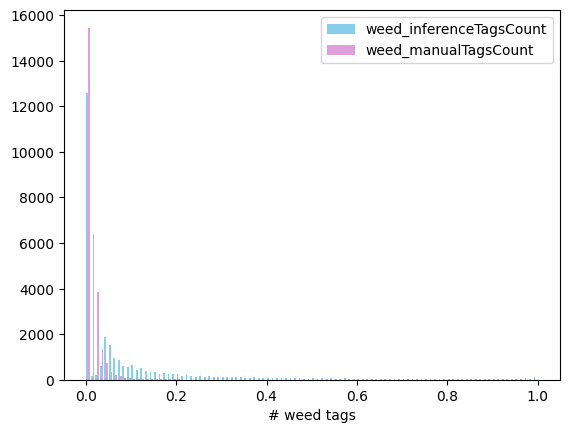

In [57]:
#SHOW HISTOGRAMS
colors = ['skyblue', 'plum']
names = [f'weed_inferenceTagsCount', f'weed_manualTagsCount']

plt.hist([filtered_one_weed_type_df['weed_inferenceTagsCount_normalized'], filtered_one_weed_type_df['weed_manualTagsCount_normalized']], histtype='bar',
                color=colors, label=names, density=False, bins = 100);
plt.xlabel('# weed tags')
plt.legend()
plt.show()

In [10]:
# GET 
unique_weed_types, count_unique_weed_types = np.unique(one_weed_type_df['weed_types_ids_list'].explode(), return_counts=True)
unique_weed_types, count_unique_weed_types = np.unique(one_weed_type_df['weed_types_ids'], return_counts=True)

interesting_weed_types = unique_weed_types[np.argsort(count_unique_weed_types)[:-4]]
interesting_weed_names = np.vectorize(cat_dict_names.get)(interesting_weed_types)
interesting_weed_df = one_weed_type_df[one_weed_type_df['weed_types_ids'].isin(interesting_weed_types)].reset_index()
interesting_weed_df['wideImageID'] = get_wide_images_list(interesting_weed_df)
interesting_weed_df = interesting_weed_df.sort_values('num_weed_tags', ascending=False).reset_index()

100%|██████████| 2/2 [00:05<00:00,  2.86s/it]


In [ ]:
dect
print(f"")

In [70]:
one_weed_type_df.columns

Index(['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'imageID',
       'identifier', 'parcelID', 'snapshotDate', 'timeGps', 'uploadDate',
       'fieldID', 'cropID', 'flightID', 'clientID', 'heightAboveGround',
       'quality', 'lat', 'lon', 'flag', 'healthy', 'expertReview',
       'taggerReview', 'taggerDone', 'autoDone', 'blackList', 'hasTiles',
       'format', 'height', 'width', 'focalLength', 'deleted', 'comment',
       'stats', 'stamp', 'plantReport', 'orderID', 'cameraFileName', 'ignored',
       'flightTargetHeight', 'cameraDegree', 'contrast', 'brightness',
       'sharpness', 'typeId', 'groupUUID', 'cameraModel', 'footprintArea',
       'footprintGeography', 'objectDistance', 'cameraAngle',
       'tagsLastVersion', 'imgUrl', 'fieldName', 'farmID', 'farmName',
       'clientName', 'fieldGeojson', 'cropName', 'num_weed_tags',
       'weed_types_ids_list', 'weed_areaPercentage', 'weed_inferenceTagsCount',
       'uploadDate_time', 'uploadDate_date', 'num_weed

In [25]:
# CREATE "SAMPLED DATAFRAME" BY UNIFORM SAMPLING THE DISTRIBUTION OF "NUM WEED TAGS"

weights = weeds_images_df['num_weed_tags'] / weeds_images_df['num_weed_tags'].sum()
# Sample 100 rows using the computed weights
sampled_df = weeds_images_df.sample(n=100, weights=weights, replace=False).reset_index()

sampled_df['wideImageID'] = get_wide_images_list(sampled_df)

100%|██████████| 10/10 [01:40<00:00, 10.05s/it]


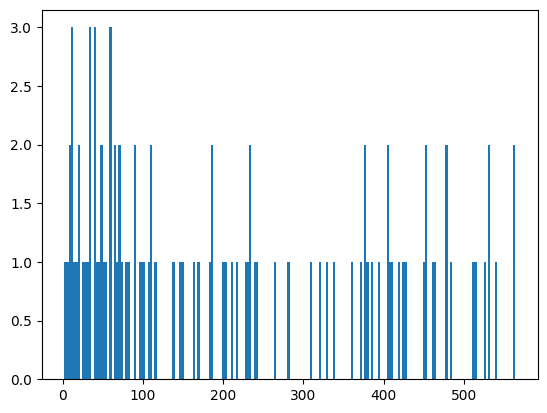

In [5]:
plt.hist(sampled_df['num_weed_tags'], bins = 200)
plt.show()

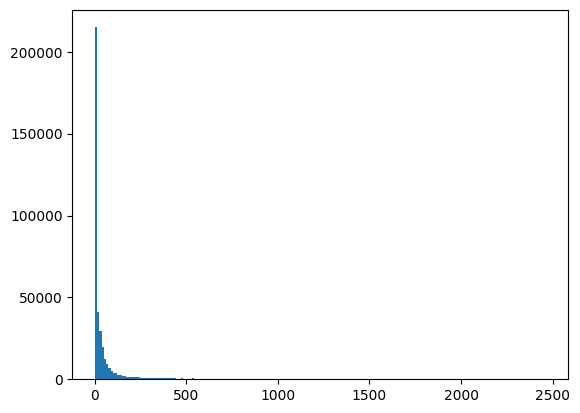

In [6]:
plt.hist(weeds_images_df['num_weed_tags'], bins = 200)
plt.show()

In [ ]:
# SHOW ZOOM-WIDE COUPLE OF IMAGES FROM THE DATAFRAME


# # CHOOSE EXAMPLE IMAGE
# soybean_df = top_weeds_df[top_weeds_df['cropName']=='Soybean'].reset_index()
# earliest_soy_images = soybean_df[soybean_df['uploadDate_date'] == soybean_df['uploadDate_date'].min()].reset_index()
# latest_soy_images = soybean_df[soybean_df['uploadDate_date'] == soybean_df['uploadDate_date'].max()].reset_index()

# corn_df = top_weeds_df[top_weeds_df['cropName']=='Corn'].reset_index()
# earliest_corn_images = corn_df[corn_df['uploadDate_date'] == corn_df['uploadDate_date'].min()].reset_index()
# latest_corn_images = corn_df[corn_df['uploadDate_date'] == corn_df['uploadDate_date'].max()].reset_index()

# latest_image_in_df = top_weeds_df.loc[top_weeds_df['uploadDate_time'].idxmax()]['imageID']
# earliest_image_in_df = top_weeds_df.loc[top_weeds_df['uploadDate_time'].idxmin()]['imageID']
# random_image_id = random.sample(list(top_weeds_df['imageID']), 1)[0]


try_df = interesting_weed_df
# df_to_show = try_df.head(5)
df_to_show = try_df

for i in range(len(df_to_show)):
    example_image_id = df_to_show['imageID'][i]
    # SHOW IMAGES
    print(f"Zoom image id: {example_image_id}")
    image_data = df_to_show[df_to_show['imageID'] == example_image_id].reset_index(drop=True)

    # image_data = df_to_show[df_to_show['imageID'] == example_image_id]
    matching_wide_image_id = int(image_data.at[0, 'wideImageID'])
    print(f"Wide image id: {matching_wide_image_id}")
    image_num_tags = image_data.at[0, 'num_weed_tags']
    image_crop_name = image_data.at[0, 'cropName']
    upload_date = image_data.at[0, 'uploadDate_date']
    weed_types = image_data.at[0, 'weed_types_ids_list']
    weed_types = list(map(cat_dict_names.get, weed_types))


    im_path = env.download_image(int(example_image_id))
    image = io.imread(im_path)

    wide_im_path = env.download_image(int(matching_wide_image_id))
    wide_image = io.imread(wide_im_path)

    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(image, extent=[0, image.shape[1], 0, image.shape[0]])
    axes[1].imshow(wide_image, extent=[0, wide_image.shape[1], 0, wide_image.shape[0]])


    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    fig.set_size_inches(10, 5)
    plt.suptitle(f"Crop Type: {image_crop_name}\nZoom Image ID: {example_image_id}, Wide Image ID: {matching_wide_image_id}\nuploadDate: {upload_date}\nNum Weed Tags: {image_num_tags}\nWeed types: {weed_types}")
    plt.tight_layout()
    plt.show()


In [4]:
env.eti_api.get_matching_wide_images([8576302])

[8576504]

Zoom image id: 8488573
Wide image id: 8493169


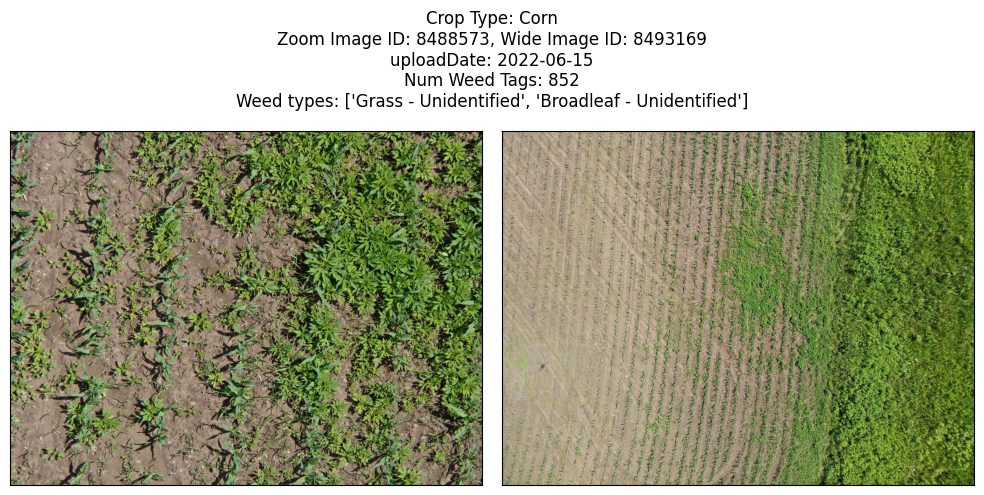

In [19]:
# SHOW ONE COUPLE BY ZOOM IMAGE ID

example_image_id = 8488573
print(f"Zoom image id: {example_image_id}")
image_data = top_weeds_df[top_weeds_df['imageID'] == example_image_id].reset_index()
matching_wide_image_id = int(image_data.at[0, 'wideImageID'])
print(f"Wide image id: {matching_wide_image_id}")
image_num_tags = image_data.at[0, 'num_weed_tags']
image_crop_name = image_data.at[0, 'cropName']
upload_date = image_data.at[0, 'uploadDate_date']
weed_types = image_data.at[0, 'weed_types_ids_list']
weed_types = list(map(cat_dict_names.get, weed_types))


im_path = env.download_image(int(example_image_id))
image = io.imread(im_path)

wide_im_path = env.download_image(int(matching_wide_image_id))
wide_image = io.imread(wide_im_path)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(image, extent=[0, image.shape[1], 0, image.shape[0]])
axes[1].imshow(wide_image, extent=[0, wide_image.shape[1], 0, wide_image.shape[0]])


for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
fig.set_size_inches(10, 5)
plt.suptitle(f"Crop Type: {image_crop_name}\nZoom Image ID: {example_image_id}, Wide Image ID: {matching_wide_image_id}\nuploadDate: {upload_date}\nNum Weed Tags: {image_num_tags}\nWeed types: {weed_types}")
plt.tight_layout()
plt.show()